<a href="https://colab.research.google.com/github/mariacmartins/bioinformatica-disciplina/blob/main/Aula_14_Single_cell_RNA_Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-cell RNA-Seq

Como os diversos tipos de células em nosso corpo expressam um transcriptoma único, o sequenciamento da população em massa convencional pode fornecer apenas o sinal de expressão médio para um conjunto de células. Atualmente, a maioria dos experimentos de análise de transcriptoma continua a se basear na suposição de que as células de um determinado tecido são homogêneas. No entanto, esses estudos podem acabar perdendo  importantes informações sobre a variabilidade célula a célula.
Nesse sentido, o **sequenciamento de RNA de uma única célula (scRNA-seq)** pode descrever moléculas de RNA em células individuais com alta resolução e em escala genômica.

Avaliar as diferenças na expressão gênica entre **células individuais** tem o potencial de identificar populações raras que não podem ser detectadas a partir de uma análise de células agrupadas. Além disso, o **scRNA-seq**, pode contribuir com a descoberta de relações regulatórias entre genes e rastrear as trajetórias de linhagens celulares distintas em desenvolvimento.

Apesar das vantagens, o single cell RNA-seq ainda é uma técnica muito recente e por isso apresenta alguns limitantes, tais como: alto custo, limitantes em questões de produzir dados com uma melhor cobertura, entre outras questões.

In [ ]:
!pip install leidenalg louvain scanpy kb-python

In [ ]:
!wget -O pbmc_1k_v3_fastqs.tar http://bit.ly/bioinfo-scrna-seq-dataset

--2021-06-14 11:56:46--  http://bit.ly/bioinfo-scrna-seq-dataset
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_fastqs.tar [following]
--2021-06-14 11:56:46--  https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_fastqs.tar
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5549312000 (5.2G) [application/x-tar]
Saving to: ‘pbmc_1k_v3_fastqs.tar’

pbmc_1k_v3_fastqs.t 100%[===================>]   5.17G  79.1MB/s    in 72s     

2021-06-14 11:57:58 (73.7 MB/s) - ‘pbmc_1k_v3_fastqs.tar’ saved [5549312000/5549312000]



In [ ]:
!tar -xf pbmc_1k_v3_fastqs.tar

In [ ]:
!ls pbmc_1k_v3_fastqs

pbmc_1k_v3_S1_L001_I1_001.fastq.gz  pbmc_1k_v3_S1_L002_I1_001.fastq.gz
pbmc_1k_v3_S1_L001_R1_001.fastq.gz  pbmc_1k_v3_S1_L002_R1_001.fastq.gz
pbmc_1k_v3_S1_L001_R2_001.fastq.gz  pbmc_1k_v3_S1_L002_R2_001.fastq.gz


In [ ]:
!kb ref -d human -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2021-06-14 12:10:45,935]    INFO [download] Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
100% 2.23G/2.23G [01:26<00:00, 27.7MB/s]
[2021-06-14 12:12:12,155]    INFO [download] Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


In [ ]:
!kb count --h5ad -i index.idx -g t2g.txt -x 10xv3 -o output --filter bustools -t 2 \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from matplotlib import pyplot as plt

In [ ]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [ ]:
results_file = 'pbmc1k.h5ad'
adata = anndata.read_h5ad("output/counts_unfiltered/adata.h5ad")
adata.var['gene_id'] = adata.var.index.values

t2g = pd.read_csv('t2g.txt', header=None, names=['tid', 'gene_id', 'gene_name'], sep='\t')
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var['gene_name'] = adata.var.gene_id.map(t2g['gene_name'])
adata.var.index = adata.var['gene_name']

adata.var_names_make_unique()

/usr/local/lib/python3.7/dist-packages/anndata/utils.py:117: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  + str(example_colliding_values)


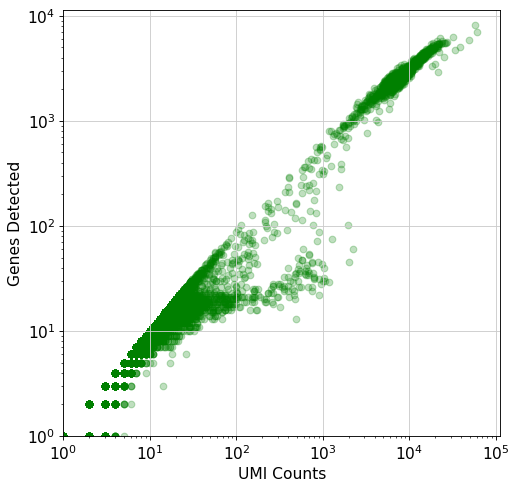

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

x = np.asarray(adata.X.sum(axis=1))[:, 0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:, 0]

ax.scatter(x, y, color='green', alpha=0.25)
ax.set_xlabel('UMI Counts')
ax.set_ylabel('Genes Detected')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)

plt.show()


normalizing counts per cell
    finished (0:00:00)


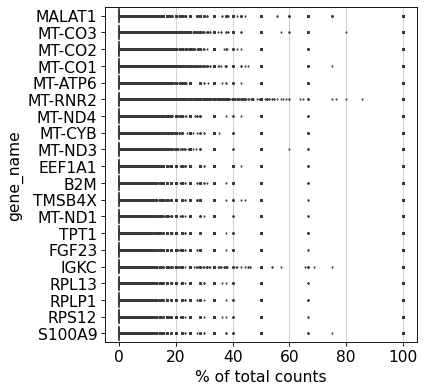

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [ ]:
# Removendo células com poucas moléculas identificadas 

adata = adata[np.asarray(adata.X.sum(axis=1)).reshape(-1) > 1000]

# Removendo genes que não foram mapeados

adata = adata[:, np.asarray(adata.X.sum(axis=0)).reshape(-1) > 0]

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 1186 × 31840
    var: 'gene_name', 'gene_id'

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 9 cells that have less than 200 genes expressed
Trying to set attribute `.obs` of view, copying.
filtered out 5886 genes that are detected in less than 3 cells


In [ ]:
adata

AnnData object with n_obs × n_vars = 1177 × 25954
    obs: 'n_genes'
    var: 'gene_name', 'gene_id', 'n_cells'

In [ ]:
mito_genes = adata.var_names.str.startswith('MT-')

adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'gene_name' as categorical


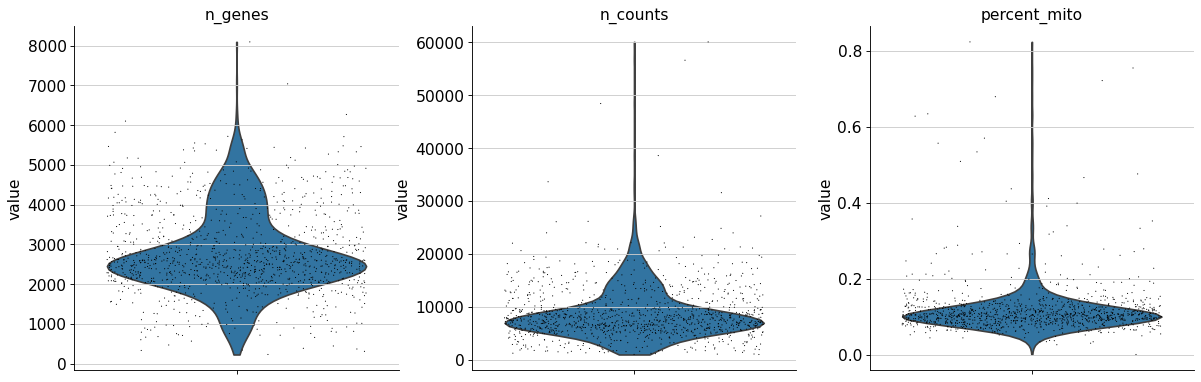

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

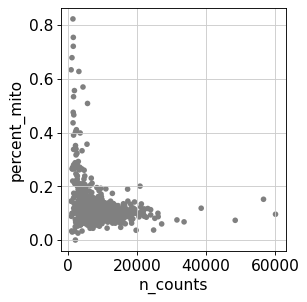

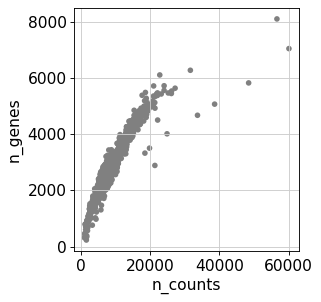

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
mask = np.logical_or(
    (adata.obs.n_genes > 200).values,
    (adata.obs.n_genes < 6500).values,
    (adata.obs.percent_mito < 0.2).values)

adata = adata[mask, :]

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 1177 × 25954
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_name', 'gene_id', 'n_cells'

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


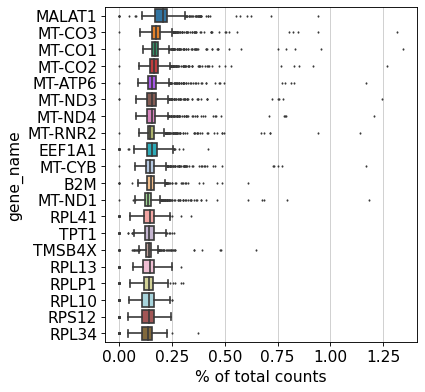

In [ ]:
sc.pp.normalize_total(adata, target_sum=10**4)
sc.pp.log1p(adata)
sc.pl.highest_expr_genes(adata, n_top=20)

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=9, min_disp=1, n_top_genes=2000, flavor='cell_ranger', n_bins=20)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


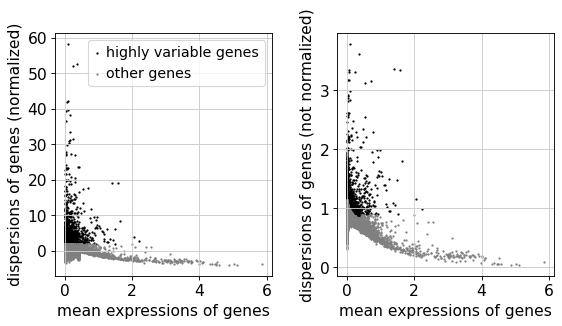

In [ ]:
sc.pl.highly_variable_genes(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


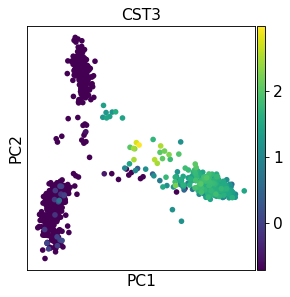

In [ ]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
sc.pl.pca(adata, color='CST3')

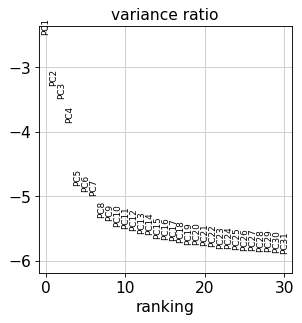

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


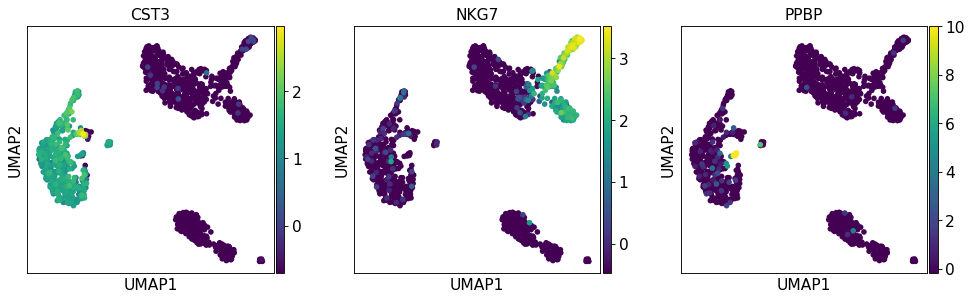

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

In [ ]:
sc.tl.louvain(adata, resolution=0.5, random_state=42)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


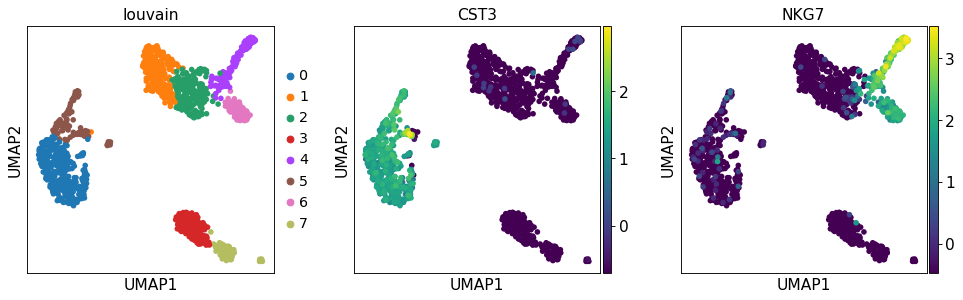

In [ ]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])

ranking genes
/usr/local/lib/python3.7/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


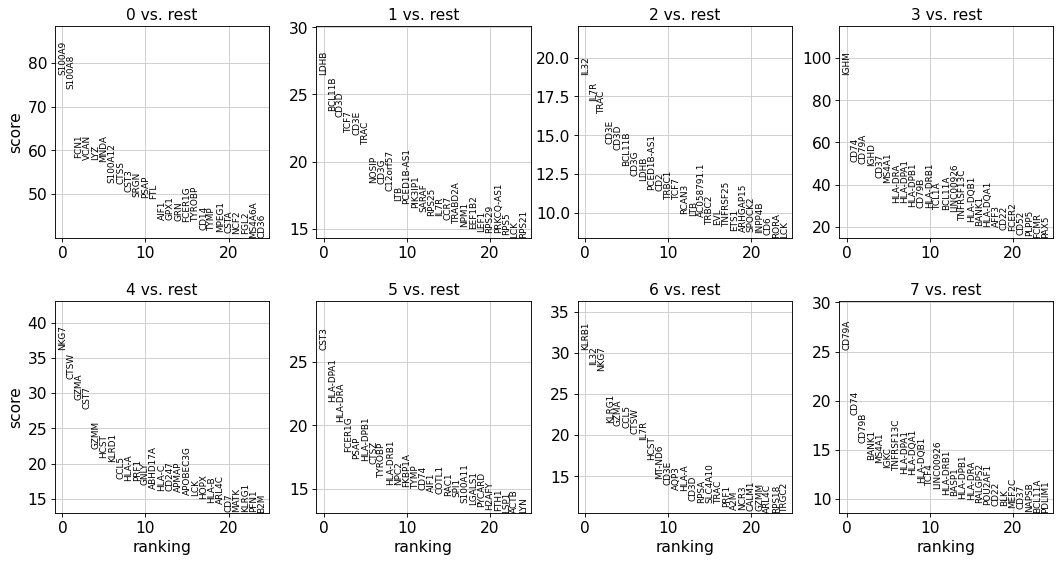

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test', corr_method='bonferroni')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

df_markers = pd.DataFrame(result['names']).head(10)
df_markers

,0,1,2,3,4,5,6,7
0,S100A9,LDHB,IL32,IGHM,NKG7,CST3,KLRB1,CD79A
1,S100A8,BCL11B,IL7R,CD74,CTSW,HLA-DPA1,IL32,CD74
2,FCN1,CD3D,TRAC,CD79A,GZMA,HLA-DRA,NKG7,CD79B
3,VCAN,TCF7,CD3E,IGHD,CST7,FCER1G,KLRG1,BANK1
4,LYZ,CD3E,CD3D,CD37,GZMM,PSAP,GZMA,MS4A1
5,MNDA,TRAC,BCL11B,MS4A1,HCST,HLA-DPB1,CCL5,IGKC
6,S100A12,NOSIP,CD3G,HLA-DRA,KLRD1,CTSZ,CTSW,TNFRSF13C
7,CTSS,CD3G,LDHB,HLA-DPA1,CCL5,TYROBP,IL7R,HLA-DPA1
8,CST3,C12orf57,PCED1B-AS1,HLA-DPB1,HLA-A,HLA-DRB1,HCST,HLA-DQA1
9,SRGN,LTB,CD2,CD79B,PRF1,NPC2,MT-ND6,HLA-DQB1


### **Identificação dos tipos celulares** (https://panglaodb.se/)

Cluster 0: DCs

Cluster 1: Células T

Cluster 2: Células T

Cluster 3: DCs

Cluster 4: Células T gama delta

Cluster 5: DCs

Cluster 6: Células T

Cluster 7: DCs